# Novoic ML challenge – text data

I decided to go for the text data challenge, as I only deal with textual data in my research and have no experience with audio and very little experience with image data. 

Given that we have nicely labelled data, I will build a classifier that can distinguish spam from ham sms.

Before tackling any new challenges, you should do some research about it in order to find out the current state of the art. There is no need to reinvent the wheel: if this problem (or any form of it) has been addressed before it makes sense to check how other people did it. Spam e-mail classification has been around for decades, starting with if-else statements in order to identify spam emails. SMS spam is a more recent problem and differs slightly from e-mail spam. We speak/text more casually on the phone, e.g. use more slang, don't construct full sentences, use abbreviations, emojis etc.

Let's load the data and have a look at it first

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn
%matplotlib inline
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import (
    train_test_split, StratifiedShuffleSplit,
    cross_val_score)

from sklearn.naive_bayes import MultinomialNB

In [2]:
# I have manually opened the .txt file in libreoffice calc which automatically picked up the 
# tab-delimiter and created a csv-file. Less "hacky" but more efficient

sms_df = pd.read_csv("test.csv", encoding="ISO-8859-1")

In [3]:
sms_df

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will â _ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
sms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
sms      5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
sms_df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Ok good, we have a fully labelled dataset 

Just for fun let's check quickly plug the unprocessed data into a NaiveBayes Classifier just to see what the accuracy is and whether a lot of feature engineering will be required. I have a feeling that it will not...

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    sms_df['sms'],
    sms_df['label'],
    test_size=0.2,
    random_state=50,
    stratify=sms_df['label']   #given we have unbalanced dataset
)

#instantiate countvectorizer 
count_vector = CountVectorizer()

#fit training data
training_data = count_vector.fit_transform(X_train)

#transform test data
testing_data = count_vector.transform(X_test)

naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train)

predictions = naive_bayes.predict(testing_data)


In [7]:
print('accuracy: {}'.format(accuracy_score(y_test, predictions)))
print('precision: {}'.format(precision_score(y_test, predictions,pos_label="ham")))
print('recall: {}'.format(recall_score(y_test, predictions,pos_label="ham")))
print('F1: {}'.format(f1_score(y_test, predictions,pos_label="ham")))


accuracy: 0.9883408071748879
precision: 0.9887179487179487
recall: 0.9979296066252588
F1: 0.9933024214322513


In [9]:
#maybse just luck? let's do cross validation

X_whole = count_vector.fit_transform(sms_df['sms'])
le = LabelEncoder()
y_enc = le.fit_transform(sms_df['label'])
scores = cross_val_score(naive_bayes, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=100))
scores

array([0.98116592, 0.98744395, 0.98475336, 0.98565022, 0.98295964,
       0.98116592, 0.98026906, 0.97847534, 0.98026906, 0.98565022])

In [10]:
scores.mean()

0.982780269058296

Ha - not sure it is worth playing around more with the data but let's quickly do some preprocessing just to show that I know how to deal with text data. Let's start with some EDA

### Exploratory data analysis

Cool, now let's get a feel for the data. We have already seen above that the dataset is unbalanced (with many more ham than spam examples) and has complete labeling (no NANs)

In [11]:
#lets create a length column so we can visualise it
sms_df['len'] = sms_df['sms'].apply(len)
sms_df.head()

,label,sms,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


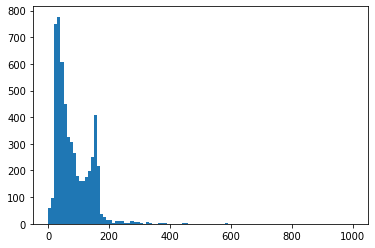

In [12]:
plot1 = plt.hist(sms_df['len'], 100, range=[0,1000])

The plot above visualises the lengths of the whole data (spam and ham). We can see a slump and then another peak. Looks like two classes. I wouldn't be surprised if the first half is mainly ham and the second mainly spam. Let's separate the data and visualise them separately

In [13]:
spam_df = sms_df[sms_df['label'] == "spam"]
ham_df = sms_df[sms_df['label'] == "ham"]

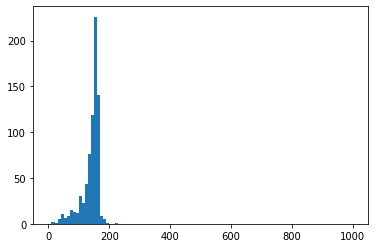

In [14]:
plot2 = plt.hist(spam_df['len'], 100, range=[0,1000])

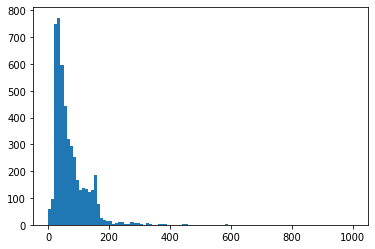

In [15]:
plot3 = plt.hist(ham_df['len'], 100, range=[0,1000])

In [16]:
ham_df.len.describe()

count    4825.000000
mean       71.214715
std        58.068635
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: len, dtype: float64

In [17]:
spam_df.len.describe()

count    747.000000
mean     139.773762
std       29.486280
min       13.000000
25%      134.000000
50%      151.000000
75%      158.500000
max      226.000000
Name: len, dtype: float64

Ok, now we know that spam messages tend to be twice as long as ham messages on average. Now let's start with the preprocessing of the data. We could also check for most common words and stuff, but given we have not deleted stopwords yet, results will not be very interesting

Before we continue, let's look at some spam examples

In [18]:
spam_messages = spam_df['sms'].tolist()

In [19]:
spam_messages[:20]

["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Ï\x83Ãº1.50 to rcv",
 'WINNER!! As a valued network customer you have been selected to receivea Ï\x83Ãº900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
 'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info',
 'URGENT! You have won a 1 week FREE membership in our Ï\x83Ãº100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18',
 'XXXMobileMovieClub: To use your credit, click 

### Normalisation
given that spam messages contain phone numbers (that you should call in order to claim your prize), e-mail addresses, URLS etc. we should normalise them since all the numbers and URLS are different in each message but are an important  feature to detect spam automatically. We can use regular expressions for that.

If the baseline classifier had shown worse results I would normalise the data and replace numbers with the keyword "number", phone numbers with a keyword "phonenumber", URLS with a keyword "webaddress" etc.

*Note: I want to invest the time and learn something new and will have a go at the speech challenge. I am not skipping this step due to laziness*

### Preprocessing 
Now comes the basic preprocessing one should always do when dealing with text. Firstly - removing stopwords- I have my own list of stopwords that I use for my research which is longer than the NLTK list, so I will use mine. Secondly - lemmatising (I personally have never seen a significant change in prediction accuracy between lemmatising and stemming and given the high accuracy I doubt that it is even necessary aka will make a difference at all)

*note: I am not deleting punctuation because spam texts seem to have way more so this can be used as a feature*

In [20]:
stop_words_file = 'data/SmartStoplist.txt'

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split())
        
        
def preprocess(raw_text):

    # convert to lower case and split
    words = raw_text.lower().split()

    # remove stopwords
    cleaned_words = []

    for word in words:
        lemmatizer = WordNetLemmatizer()
        word = lemmatizer.lemmatize(word)
        if word not in stop_words:
            cleaned_words.append(word)

    return " ".join(cleaned_words)

### Feature Engineering
Now that we have our preprocessing function we can apply them to the data and start building our model. Using Word2Vec, Glove, BERT or any other vectors will not work for this dataset due to the abbreviations and colloquial language so I will use Bag-of-Words model with one of the scikit-learn vectorisers


In [21]:
sms_df['sms']= sms_df['sms'].apply(preprocess)

In [22]:
# out of curiosity we can also apply them to the previously created spam and ham dfs and check for the most
#common words in each category

In [24]:
ham_df['sms']= ham_df['sms'].apply(preprocess)
spam_df['sms']= spam_df['sms'].apply(preprocess)

/home/lisanka/anaconda3/envs/FOURTH_study/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/lisanka/anaconda3/envs/FOURTH_study/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
Counter(" ".join(ham_df["sms"]).split()).most_common(30)

[("i'm", 369),
 ('2', 284),
 ('&lt;#&gt;', 276),
 ('ur', 235),
 ('call', 226),
 ('like', 224),
 ('.', 222),
 ('wa', 221),
 ('good', 187),
 ('?', 181),
 ('â\x95', 175),
 ('time', 172),
 ("i'll", 167),
 ('...', 162),
 ('love', 157),
 ('4', 156),
 ("don't", 125),
 ('day', 124),
 ('send', 121),
 ('home', 110),
 ('_', 106),
 ('back', 101),
 ('hope', 99),
 ('ha', 96),
 ('give', 94),
 ('me.', 91),
 ('happy', 91),
 ("it's", 91),
 ('pls', 89),
 ('thing', 86)]

*Note: I usually delete punctuation so my stopwordlist does not include "don't" "it's" etc. Could add them but given the high accuracy shown above I do not think it's necessary*

In [26]:
Counter(" ".join(spam_df["sms"]).split()).most_common(20)

[('call', 350),
 ('free', 180),
 ('2', 169),
 ('ur', 144),
 ('txt', 136),
 ('text', 127),
 ('mobile', 119),
 ('claim', 108),
 ('reply', 102),
 ('&', 98),
 ('4', 93),
 ('stop', 89),
 ('now!', 70),
 ('send', 65),
 ('won', 64),
 ('nokia', 64),
 ('tone', 64),
 ('service', 61),
 ('prize', 60),
 ('win', 59)]

so we can see that there is a big difference in most common words. almost half of the spam messages contain the word "call" whereas less than 5% of the ham messages contain the word "call". let's visualise them in a word cloud

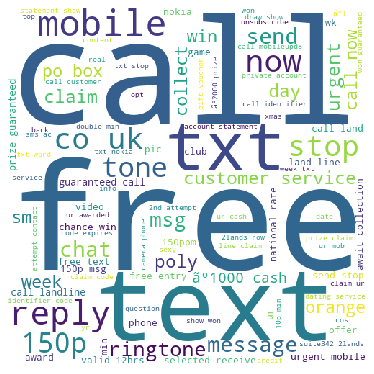

In [27]:
from wordcloud import WordCloud

sms_words = '' 

for sms in spam_df["sms"]: 
      
    # typecaste each val to string 
    #val = str(val) 
  
    # split the value 
    tokens = sms.split() 
      
      
    sms_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(sms_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

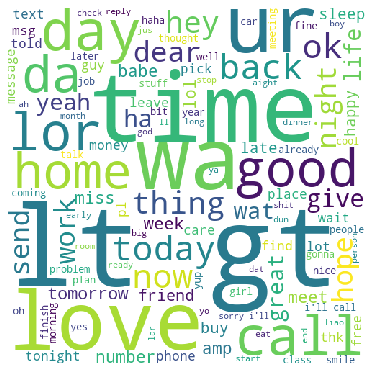

In [28]:
sms_words = '' 

for sms in ham_df["sms"]: 
      
    # typecaste each val to string 
    #val = str(val) 
  
    # split the value 
    tokens = sms.split() 
      
      
    sms_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(sms_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Let's leave it for now and start building a model

In [58]:

y = sms_df['label']

vectorizer = CountVectorizer() #(ngram_range=(1, 3))  #CountVectoriser increased performance by around 0.5% compared to tf-idf
#vectorizer = TfidfVectorizer() #(ngram_range=(1, 2))
X = sms_df['sms']


### Model Training

I usually go for SVM for supervised text classification tasks, so that's just personal experience - so I will give it a go this time too. I use a linear kernel because text data contains a large number of features and using a nonlinear kernel would be computationally expensive

In [59]:

classifier = svm.SVC(kernel="linear")


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=50,
    stratify=y
)


# train
vectorize_train = vectorizer.fit_transform(X_train)
classifier.fit(vectorize_train, y_train)


# score
vectorize_test = vectorizer.transform(X_test)
score = classifier.score(vectorize_test, y_test)
print(score) 


0.9856502242152466


In [60]:
pred = classifier.predict(vectorize_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, pred)))
print('Precision score: {}'.format(precision_score(y_test, pred,pos_label="ham")))
print('Recall score: {}'.format(recall_score(y_test, pred,pos_label="ham")))
print('F1 score: {}'.format(f1_score(y_test, pred,pos_label="ham")))

Accuracy score: 0.9856502242152466
Precision score: 0.9837067209775967
Recall score: 1.0
F1 score: 0.9917864476386037


Ok that looks good (although nothing has changed compared to the results above). We need to do cross-valication in order to judge the accuracy of the model (we have not done that above, but it looks like results are the same and the deletion of stopwords and lemmatisation did not make a difference)

In [61]:
#fit_transform on whole data, not as previously on train and test separately to avoid information leakage
X_whole = vectorizer.fit_transform(sms_df['sms'])
le = LabelEncoder()
y_enc = le.fit_transform(y)
scores = cross_val_score(classifier, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=50))
scores

array([0.98565022, 0.97757848, 0.9838565 , 0.97757848, 0.9838565 ,
       0.98295964, 0.98654709, 0.98206278, 0.98654709, 0.9838565 ])

In [62]:
scores.mean()

0.9830493273542601

Playing around with the parameters a bit I noticed that CountVectoriser performs marginally better than tfidf and including bigrams as features did not change the accuracy

I want to get a feel for what sort of messages are wrongly classified so I will create a test set manually and print out the results and store them

In [63]:
import csv
train_data = sms_df[:4400] # 4400 items
test_data = sms_df[4400:] # 1172 items


# train
vectorize_text = vectorizer.fit_transform(train_data['sms'])
classifier.fit(vectorize_text, train_data['label'])


wrong_results = []

csv_arr = []
for index, row in test_data.iterrows():
    answer = row[0]
    text = row[1]
    vectorize_text = vectorizer.transform([text])
    predict = classifier.predict(vectorize_text)[0]
    if predict == answer:
        result = 'right'
    else:
        result = 'wrong'
        wrong_results.append([text, answer, predict])
    csv_arr.append([len(csv_arr), text, answer, predict, result])


# write csv
with open('test_score.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=';',
            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['#', 'text', 'answer', 'predict', result])

    for row in csv_arr:
        spamwriter.writerow(row)

In [64]:
len(wrong_results)

21

In [65]:
wrong_results

[['chance win free bluetooth headset simply reply back \\adp\\""',
  'spam',
  'ham'],
 ['3. received mobile content. enjoy', 'spam', 'ham'],
 ['explicit sex 30 secs? ring 02073162414 now! cost 20p/min', 'spam', 'ham'],
 ['money won wining number 946 wot', 'spam', 'ham'],
 ['sunshine quiz! win super sony dvd recorder canname capital australia? text mquiz 82277.',
  'spam',
  'ham'],
 ['babe chloe, u? wa smashed saturday night, wa great! wa weekend? missing me? sp visionsms.com text stop stop 150p/text',
  'spam',
  'ham'],
 ['(career tel) added contact indyarocks.com send free sms. remove phonebook - sm &lt;#&gt;',
  'ham',
  'spam'],
 ['warner village 83118 colin farrell swat wkend @warner village & 1 free med. popcorn!just show msg+ticket@kiosk.valid 4-7/12. t&c @kiosk. reply sony 4 mre film offer',
  'spam',
  'ham'],
 ['goal! arsenal 4 (henry, 7 liverpool 2 henry score simple shot 6 yard pas bergkamp give arsenal 2 goal margin 78 mins.',
  'spam',
  'ham'],
 ['amy, sending free pho

From the results we see (in csv - I prefer looking at text data in csv files) that from the 21 wrongly classified messages 20 were supposed to be spam but got classisfied as ham and only 1 was supposed to be ham and got classified as spam. I think this is more favourable than the other way around - it's better to accidentally receive a spam message than missing an important ham message. From those few results it's hard to find a pattern which is worth hard coding and engineering some additional features.

Also, given the high accuracy I do not believe that experimenting with other classifiers will get it much higher

### Final remarks

It seems like spam and ham are distinct enough to achieve high results even without preprocessing. So there is little point to engineer any more features.

It would be interesting to see how generalisable this model is. I tried to find another dataset to apply the classifier but struggled finding one. I found this paper:
https://www.researchgate.net/publication/313608076_A_Review_on_Mobile_SMS_Spam_Filtering_Techniques?enrichId=rgreq-0cfbddc2fd16ff5e756b315f4e80441b-XXX&enrichSource=Y292ZXJQYWdlOzMxMzYwODA3NjtBUzo0NjA3MjUyNzg3NzczNDRAMTQ4Njg1Njg3NDkyMw%3D%3D&el=1_x_3&_esc=publicationCoverPdf

Table 2 shows a variety of datasets, however, they were either
- not in english
- not sms data
- broken link
- no labelling (NUS corpus) because mainly (if not all) ham


Thank you for reading!
Lisa